In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats

import pandapower as pp
from pandapower.networks import case2848rte
%config InlineBackend.figure_format = 'png2x'
plt.style.use('../plot_style.mplstyle')

/var/folders/0t/9z26630n32l3qw5w80zvvjqw0000gn/T/ipykernel_7914/2312485213.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


ModuleNotFoundError: No module named 'seaborn'

#### Set random seed

In [ ]:
## Set random seeds
random.seed(10)
np.random.seed(20)

In [ ]:
# Load the network
net = case2848rte()

/opt/homebrew/lib/python3.11/site-packages/pandapower/io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
/opt/homebrew/lib/python3.11/site-packages/pandapower/io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
/opt/homebrew/lib/python3.11/site-packages/pandapower/io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
/opt/homebrew/lib/python3.11/site-packag

#### Configure power grid 

In [ ]:
## Set the power generation cost
# Load power generation cost (Preset in in the file 'Set_poly_cost.ipynb)
gen_price = pd.read_csv('gen_price.csv', index_col=0, header=0)

# Get the generator indices in the poly_cost dataframe ['gen']
gen_idx_in_poly_cost_gen = net.poly_cost[net.poly_cost.et=='gen'].element.values.astype(np.int64)

# Get the generator indices in the poly_cost dataframe
gen_idx_in_poly_cost = np.arange(len(net.poly_cost))[(net.poly_cost.et == 'gen').values]

# CANNOT use successive slcing twice, it won't work
temp = net.poly_cost.cp1_eur_per_mw.iloc[gen_idx_in_poly_cost]
temp.iloc[gen_idx_in_poly_cost_gen] = gen_price['price_term1'].values
net.poly_cost.cp1_eur_per_mw.iloc[gen_idx_in_poly_cost] = temp

temp.iloc[gen_idx_in_poly_cost_gen] = gen_price['price_term2'].values
net.poly_cost.cp2_eur_per_mw2.iloc[gen_idx_in_poly_cost] = temp

/var/folders/0t/9z26630n32l3qw5w80zvvjqw0000gn/T/ipykernel_15745/3490275465.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  net.poly_cost.cp1_eur_per_mw.iloc[gen_idx_in_poly_cost] = temp
/var/folders/0t/9z26630n32l3qw5w80zvvjqw0000gn/T/

In [ ]:
# Set the sgen NOT in service
net.sgen.in_service = False

# Set maximum generation capacity
net.gen.max_p_mw = 500

## maximum line and transformer loading percent determine the convergence
# Set maximum line loading percentage
net.line.max_loading_percent = 10000
# Set transformer loading percent as unlimited
net.trafo.max_loading_percent = 1e20

# Set min_p_mw at slack bus
net.ext_grid.min_p_mw = 0

#### Set renewable power generation

In [ ]:
#############################################################################################
# Get bus
all_bus = np.arange(0, net.bus.shape[0])

# Manually set renewable generator bus 
wind_bus = pd.read_csv('zones/wind_bus.csv', index_col=None, header=None).to_numpy().reshape((-1))
wind_bus = wind_bus - 1 # Bus should be 0-indexed
wind_bidx = np.isin(net.gen.bus.values, wind_bus) # Get the Boolean index of renewable generators

# Get generator bus bidx (slack bus NOT included)
gen_bidx = np.isin(all_bus, net.gen.bus.values)
# Get generator bus no (including renewable, thermal and slack buses)
# slack_gen_no = np.isin(net.bus.name-1, net.gen.bus)

# Get load buses no
load_bidx = np.isin(all_bus, net.load.bus.values)

In [ ]:
# The array to store 'p_mw' of net.res_bus
bus_features = ['p_mw']
p_bus_list = np.empty((net.bus.shape[0], len(bus_features)))

# The arrry to store corresponding results 'net.res_gen.p_mw' & 'net.res_gen.va_degree'
# For the time being, we only care about 'p_mw'
# p_gen_features = ['p_mw', 'va_degree']
gen_features = ['p_mw']
p_gen_list = np.empty((net.gen.shape[0]*len(gen_features), 1))
p_max_gen_list = np.empty((net.gen.shape[0], 1))

# The array to store p_mw at load buses
p_load_list = np.empty((net.load.shape[0], 1))

# The array to store corresponding results 'net.res.line...' (there are multiple features in line result).
# Only need to keep the following five features in DC OPF.
# For the time being, we only care about 'p_mw'
# pf_line_features = ['p_from_mw', 'i_ka', 'va_from_degree', 'va_to_degree', 'loading_percent']
line_features = ['p_from_mw']
pf_line_list = np.empty((net.line.shape[0]*len(line_features), 1))
lp_line_list = np.empty((net.line.shape[0], 1))

# The array to store slack bus 'max_p_mw'
p_slack_max_list = []

# Global features
shedding_reserve_list = []
total_cost_list = []

In [ ]:
# Load gen/load bus in individual zone (globals() dynamicly create variables)
num_zones = 16
for i in range(1, num_zones+1):
    # Load bus
    var_name = f'zone{i}_load_bus'
    globals()[var_name] = pd.read_csv(f'zones/{var_name}.csv', index_col=None, header=None).to_numpy() - 1
    var_name = f'zone{i}_load_bidx'
    globals()[var_name] = np.isin(net.load.bus, globals()[f'zone{i}_load_bus'])

    # Gen bus
    var_name = f'zone{i}_gen_bus'
    globals()[var_name] = pd.read_csv(f'zones/{var_name}.csv', index_col=None, header=None).to_numpy() - 1
    var_name = f'zone{i}_gen_bidx'
    globals()[var_name] = np.isin(net.gen.bus, globals()[f'zone{i}_gen_bus'])

    # Wind bus
    var_name = f'zone{i}_wind_bus'
    globals()[var_name] = pd.read_csv(f'zones/{var_name}.csv', index_col=None, header=None).to_numpy() - 1
    var_name = f'zone{i}_wind_bidx'
    globals()[var_name] = np.isin(net.gen.bus, globals()[f'zone{i}_wind_bus'])

FileNotFoundError: [Errno 2] No such file or directory: 'zones/zone1_load_bus.csv'

#### Generate RV (Overall 16 zones)

In [ ]:
# Set number of RVs (Only used for generating plots, DOES NOT HAVE ANY EFFECT ON THE SIMULATION)
num_rv = 1000

##### Load - Truncated normal distribution

In [ ]:
# Set distribution parameters
mu = np.array([50, 75, 100, 48, 81, 98, 52, 83, 45, 85, 98, 53, 81, 98, 47, 85])
std = np.array([15, 20, 15, 12, 21, 15, 13, 20, 12, 18, 16, 13, 20, 15, 12, 20])
rv_min = np.array([10, 25, 60, 9, 23, 60, 7, 21, 14, 25, 55, 9, 23, 55, 8, 21])
rv_max = np.array([90, 125, 140, 87, 139, 136, 97, 145, 76, 145, 141, 97, 139, 141, 86, 149])

# Generate distributions and RVs
for i in range(1, num_zones+1):
    # Left / right truncation in terms of standard deviation
    a = (rv_min[i-1] - mu[i-1]) / std[i-1]
    b = (rv_max[i-1] - mu[i-1]) / std[i-1]

    var_name = f'lx{i}'
    globals()[var_name] = np.linspace(rv_min[i-1], rv_max[i-1], num_rv)

    # Generate distributions
    var_name = f'tn{i}'
    globals()[var_name] = stats.truncnorm(loc=mu[i-1], scale=std[i-1], a=a, b=b)

    # Generate random variables and corresponding PDF
    var_name = f'tn_rv{i}'
    globals()[var_name] = globals()[f'tn{i}'].rvs(size=num_rv)
    var_name = f'tn_pdf{i}'
    globals()[var_name] = globals()[f'tn{i}'].pdf(x=globals()[f'lx{i}'])

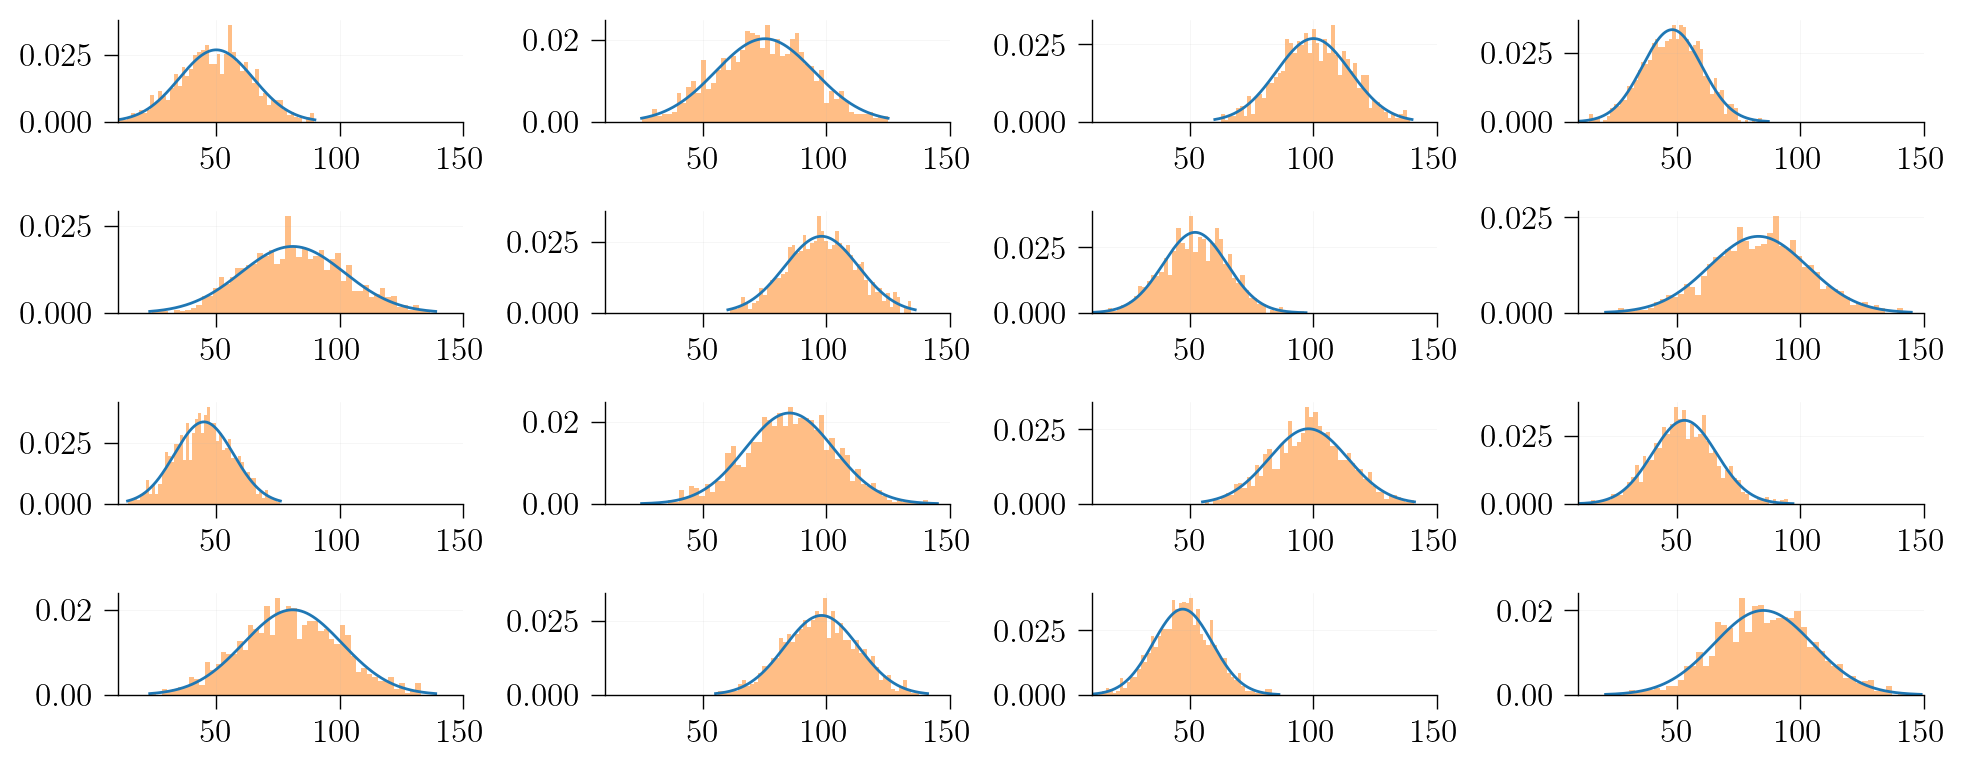

In [ ]:
## Plot load RVs
fig = plt.figure(figsize=(10, 4))

for i in range(1, num_zones+1):
    ax = fig.add_subplot(4, 4, i)
    ax.plot(globals()[f'lx{i}'], globals()[f'tn_pdf{i}'])
    _, _, _ = ax.hist(globals()[f'tn_rv{i}'], bins=50, density=True, alpha=0.5)
    ax.set_xlim(10, 150)

plt.show()
plt.close('all')

##### Wind speed --> wind power

In [ ]:
## Define func wind speed --> wind energy
def windSpeedToPower(w):
    """
        input:
            w: wind speed (m/s), ndarray
        output:
            P: wind power (MW), ndarray
    """
    # Check the input type
    if type(w) != np.ndarray:
        raise TypeError("'w' should be 'numpy.ndarray'.")
    # Set maximum allowed wind power generation
    Pr = 100.
    # No wind power if w < wi
    wi = 1.
    # Wind speed that reaches maximum allowed wind power capacity
    wr = 15.
    # Convert wind speed to wind power
    P = Pr*(w**3 - wi**3)/(wr**3 - wi**3)
    # Get index of wind speed less than wi
    left_index = (w < wi)
    P[left_index] = 0.
    # Get index of wind speed bigger than wi
    right_index = (w > wr)
    P[right_index] = Pr

    return P

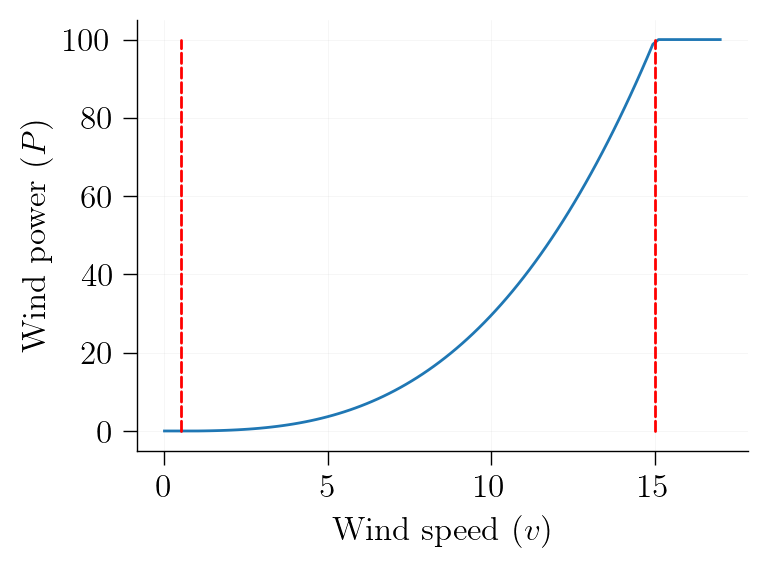

In [ ]:
w = np.linspace(0, 17, 100)
P = windSpeedToPower(w)
plt.plot(w, P)
plt.vlines(x=0.5, ymin=0, ymax = 100, color='red', linestyles='dashed')
plt.vlines(x=15., ymin=0, ymax = 100, color='red', linestyles='dashed')
plt.xlabel('Wind speed ($v$)')
plt.ylabel('Wind power ($P$)')
plt.show()
plt.close('all')

##### Wind - (Converted from truncated Weibull distribution)

In [ ]:
# Set parameters
loc = 0.
scale = np.array([8, 8.2, 12, 8.1, 7.9, 7.7, 8, 8.3, 7.8, 8.1, 12.5, 8.5, 7.5, 7.7, 8, 8.3])
shape = np.array([2, 1.8, 8, 1.9, 2.1, 1.9, 2.1, 2.0, 1.8, 1.8, 8.1, 2.2, 1.8, 2.0, 2.0, 2.5])

# Generate distributions and RVs
lx = np.linspace(0, 30, num_rv)
for i in range(1, num_zones+1):
    # Generate distributions
    var_name = f'twb{i}'
    globals()[var_name] = stats.weibull_min(loc=loc, c=shape[i-1], scale=scale[i-1])

    # Generate random variables and corresponding PDF
    var_name = f'twb_rv{i}'
    globals()[var_name] = globals()[f'twb{i}'].rvs(size=num_rv)
    var_name = f'twb_pdf{i}'
    globals()[var_name] = globals()[f'twb{i}'].pdf(x=lx)

    # Conver wind speed to wind power
    var_name = f'wind_power{i}'
    globals()[var_name] = windSpeedToPower(globals()[f'twb_rv{i}'])

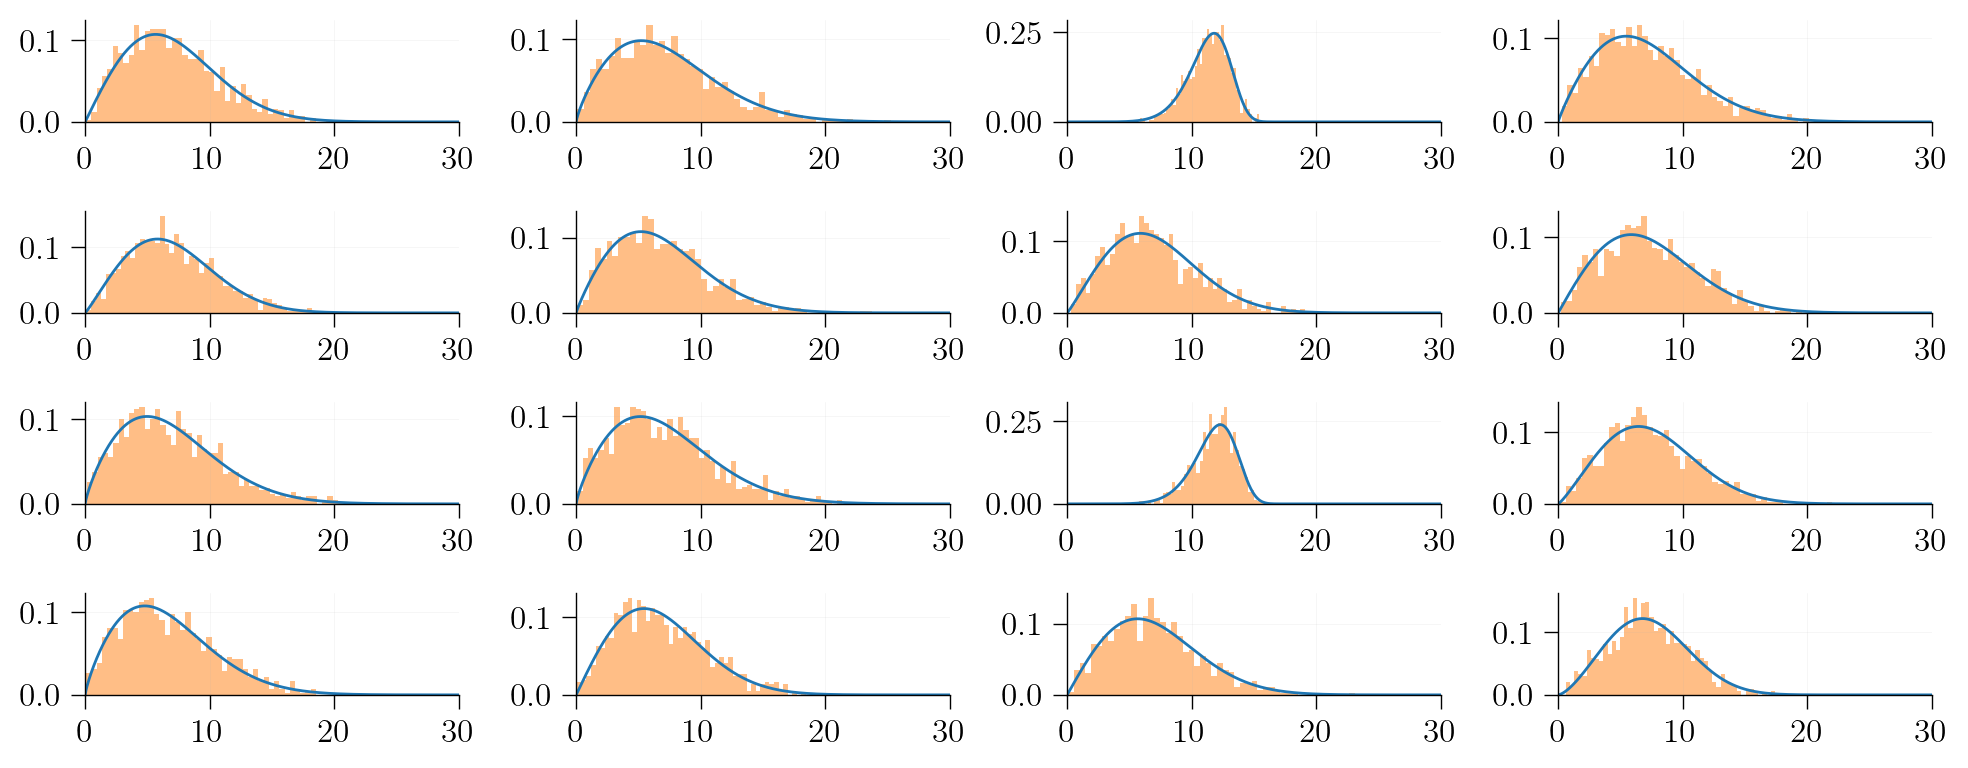

In [ ]:
## Plot wind speed RVs
fig = plt.figure(figsize=(10, 4))

for i in range(1, num_zones+1):
    ax = fig.add_subplot(4, 4, i)
    ax.plot(lx, globals()[f'twb_pdf{i}'])
    _, _, _ = ax.hist(globals()[f'twb_rv{i}'], bins=50, density=True, alpha=0.5)
    ax.set_xlim(0, 30)

plt.show()
plt.close('all')

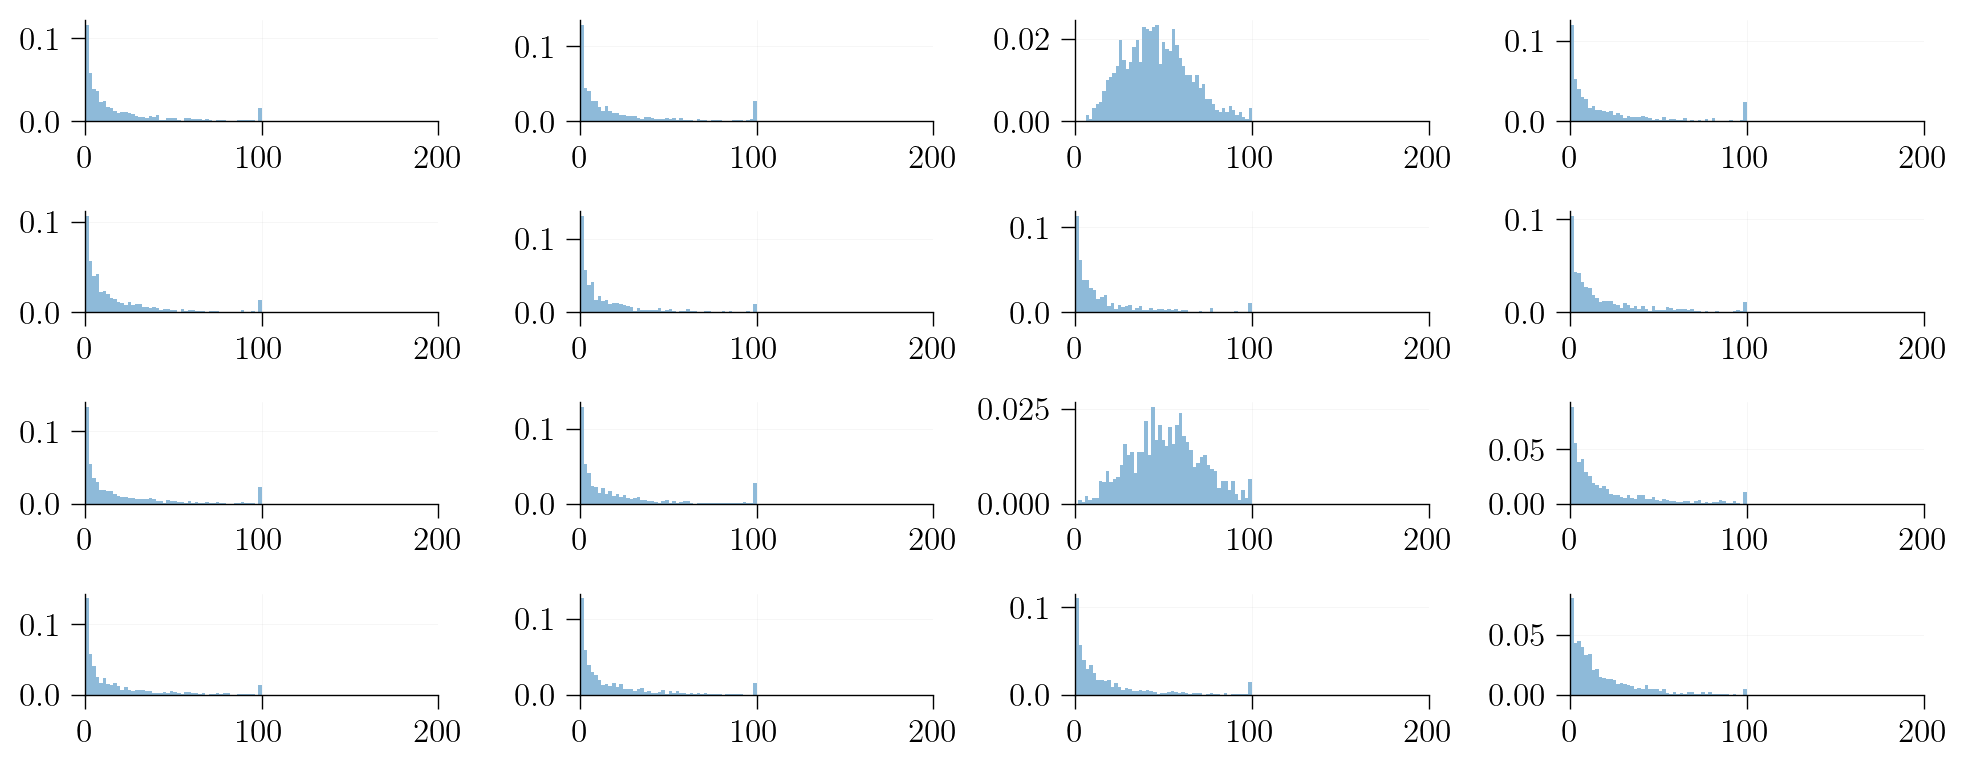

In [ ]:
## Plot wind power
fig = plt.figure(figsize=(10, 4))

for i in range(1, num_zones+1):
    ax = fig.add_subplot(4, 4, i)
    _, _, _ = ax.hist(globals()[f'wind_power{i}'], bins=50, density=True, alpha=0.5)
    ax.set_xlim(0, 200)

plt.show()
plt.close('all')

In [ ]:
## Read correlation matrix
corr_matrix = pd.read_csv('corr_matrix/corr_matrix.csv', index_col=None, header=None).to_numpy()

## Read load /wind proportions
for i in range(1, num_zones+1):
    var_name = f'zone{i}_load_proportion'
    globals()[var_name] = pd.read_csv(f'zones/zone{i}_load_proportion.csv', 
                                      index_col=None, header=None).to_numpy().reshape((-1))
    
    var_name = f'zone{i}_wind_proportion'   
    globals()[var_name] = pd.read_csv(f'zones/zone{i}_wind_proportion.csv', 
                                      index_col=None, header=None).to_numpy().reshape((-1))

#### Generate synthetic data

In [ ]:
## Number of grid variable samples
max_iteration = 2000

## Numbe rof target OPF samples (solutions)
num_samples = 1000

## Generate correlated RV
# Generate multivariate normal PDF (Standard normal PDF --> covariance = correlation)
mvnorm = stats.multivariate_normal(cov=corr_matrix)
mvnorm_rv = mvnorm.rvs(size=max_iteration)
# Get corresponding CDF (CANNOT USE MULTIVARIATE_NOMRAL CDF)
rv_cdf = stats.norm.cdf(mvnorm_rv)
# Generate RV under target PDFs using inverse CDF
for i in range(1, num_zones+1):
    var_name = f'L{i}_ref'
    globals()[var_name] = globals()[f'tn{i}'].ppf(rv_cdf[:, i-1])
    var_name = f'R{i}_ref'
    globals()[var_name] = windSpeedToPower(globals()[f'twb{i}'].ppf(rv_cdf[:, i+num_zones//2]))

NameError: name 'corr_matrix' is not defined

In [ ]:
# Set RV index
j = 0   # Index for max_iteration
num = 0 # Index for OPF solutions
while j < max_iteration:
    ## Set p_mw at load buses and max_p_mw / min_p_mw at wind buses
    for i in range(1, num_zones+1):
        # Generate values for the rest of loads and RES
        var_name = f'L_{i}'
        globals()[var_name] = globals()[f'L{i}_ref'][j] * globals()[f'zone{i}_load_proportion']
        var_name = f'R_{i}'
        globals()[var_name] = globals()[f'R{i}_ref'][j] * globals()[f'zone{i}_wind_proportion']

        # Set p_mw at load buses
        net.load.p_mw[globals()[f'zone{i}_load_bidx']] = globals()[f'L_{i}']

        # Set max_p_mw adn min_p_mw at wind buses
        net.gen.max_p_mw[globals()[f'zone{i}_wind_bidx']] = globals()[f'R_{i}']
        net.gen.min_p_mw[globals()[f'zone{i}_wind_bidx']] = globals()[f'R_{i}']
    
    # Set 'max_p_mw' at slack bus 
    if net.load.p_mw.sum() >= net.gen.max_p_mw.sum():
        net.ext_grid.max_p_mw = net.load.p_mw.sum() - net.gen.max_p_mw.sum()
    else:
        net.ext_grid.max_p_mw = 0.

    ## Run OPF solver (ignore unconverged cases) and collect data
    try:
        ## Run DCOPP
        pp.rundcopp(net)

        ## Collect data
        # p_mw at load buses
        p_load = net.load.p_mw.to_numpy().reshape((-1, 1))
        p_load_list = np.concatenate([p_load_list, p_load], axis=1)
        # max_p_mw at gen buses
        p_max_gen = net.gen.max_p_mw.to_numpy().reshape((-1, 1))
        p_max_gen_list = np.concatenate([p_max_gen_list, p_max_gen], axis=1)
        # max_p_mw at slack bus
        p_slack_max_list.append(net.ext_grid.max_p_mw.values)

        ## Collect results
        # Results of p_mw at all buses
        # order='F' means first index changes fastest while last index changes slowest
        p_bus = net.res_bus[bus_features].to_numpy().reshape((-1, len(bus_features)), order='F') 
        p_bus_list = np.concatenate([p_bus_list, p_bus], axis=1)
        # Results of p_mw at gen buses
        p_gen = net.res_gen[gen_features].to_numpy().reshape((-1, 1), order='F')  
        p_gen_list = np.concatenate([p_gen_list, p_gen], axis=1)
        # Results of power flow at all lines
        pf_line = net.res_line[line_features].to_numpy().reshape((-1, 1), order='F')
        pf_line_list = np.concatenate([pf_line_list, pf_line], axis=1)
        # Results of loading percent at all lines
        lp_line = net.res_line.loading_percent.to_numpy().reshape((-1, 1))
        lp_line_list = np.concatenate([lp_line_list, lp_line], axis=1)
        # Results of shedding and reserve
        shedding_reserve = net.load.p_mw.sum() - net.gen.max_p_mw.sum()
        shedding_reserve_list.append(shedding_reserve)
        # Results of total cost
        total_cost = net.res_cost / 1e3
        total_cost_list.append(total_cost)

        # Increment index
        num += 1

        if num >= num_samples:
            print(f'{num_samples} OPF solutions found')
            break
    except:
        print(f'No solution found for sample {j+1}')
        pass

    # Increment index
    j += 1

    # Increment index
    if j >= max_iteration:
        print(f'No sufficient samples found for {num_samples} OPF solutions')
        break

1000 OPF solutions found


#### Save synthetic data

In [ ]:
# Save synthetic data (node level)
pd.DataFrame(p_load_list[:, 1:]).to_csv('synthetic_data/p_load_data.csv')
pd.DataFrame(p_max_gen_list[:, 1:]).to_csv('synthetic_data/p_max_gen_data.csv')
pd.DataFrame(p_slack_max_list).to_csv('synthetic_data/p_slack_max_data.csv')
pd.DataFrame(p_bus_list[:, len(bus_features):]).to_csv('synthetic_data/p_bus_data.csv')
pd.DataFrame(p_gen_list[:, 1:]).to_csv('synthetic_data/p_gen_data.csv')

# Save synthetic data (edge level)
pd.DataFrame(pf_line_list[:, 1:]).to_csv('synthetic_data/pf_line_data.csv')
pd.DataFrame(lp_line_list[:, 1:]).to_csv('synthetic_data/lp_line_data.csv')

pd.DataFrame(lp_line_list[:, 1:]).to_csv('reliability_risk/lp_true_corr.csv')

# Save synthetic data (graph level)
graph_features = pd.concat([pd.Series(shedding_reserve_list, name='shedding_reserve'), 
                           pd.Series(total_cost_list, name='total_cost(10^3)')], 
                           axis=1)
graph_features.T.to_csv('synthetic_data/graph_features.csv')

In [ ]:
lp_line = pd.DataFrame(lp_line_list[:, 1:])

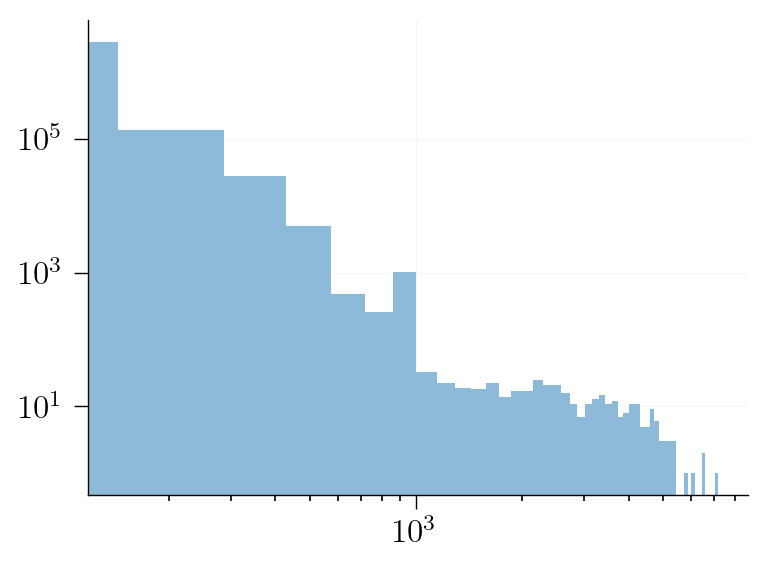

In [ ]:
_, _, _ = plt.hist(lp_line.values.flatten(), bins=50, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.show()
plt.close('all')